# Ordinal Regression of Outcomes Categorical variable

In [447]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, MaternKernel, SpectralMixtureKernel

import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.metrics import scotts_pi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data transform and EDA

In [2]:
df = pd.read_csv('msl_evasion-003.csv')

# We remove MUTUAL_KILL and keep the variables ordered as:
# VIPER_WIN = 2
# BOTH_SURVIVED = 1
# COBRA_WIN = 0

outcome_map = {
    "VIPER_WIN": 2,
    "BOTH_SURVIVED": 1,
    "COBRA_WIN": 0,
}

df = df[df.outcome != "MUTUAL_KILL"]
df.outcome = df.outcome.map(outcome_map)

log_standardise = lambda x: (np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
log_norm = lambda x: (np.log(x) - np.min(np.log(x))) / (np.max(np.log(x)) - np.min(np.log(x)))
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def norm_custom(x, minval, maxval):
    x = (x - minval) / (maxval - minval)
    return x

# log normalise data
df["lognorm_viper_launch_range"] = df.viper_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(log_norm)
df["lognorm_cobra_launch_range"] = df.cobra_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(log_norm)

# normalise data
df["norm_viper_launch_range"] = df.viper_launch_range.pipe(norm)
df["norm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(norm)
df["norm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(norm)
df["norm_cobra_launch_range"] = df.cobra_launch_range.pipe(norm)
df["norm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(norm)
df["norm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(norm)

# compute min, max vals among both cobra and viper
evasion_minval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).min()
evasion_maxval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).max()
launch_minval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).min()
launch_maxval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).max()
briefed_launch_minval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).min()
briefed_launch_maxval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).max()

# difference between evasion and launch. normalised
df["briefed_evasion_range_diff"] = df.viper_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval)) - df.cobra_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval))
df["launch_range_diff"] = df.viper_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval)) - df.cobra_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval))
df["briefed_launch_range_diff"] = df.viper_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval)) - df.cobra_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval))

# difference between time launched
df["time_at_launch_diff"] = df.viper_time_at_launch - df.cobra_time_at_launch


<Axes: xlabel='time_at_launch_diff', ylabel='briefed_launch_range_diff'>

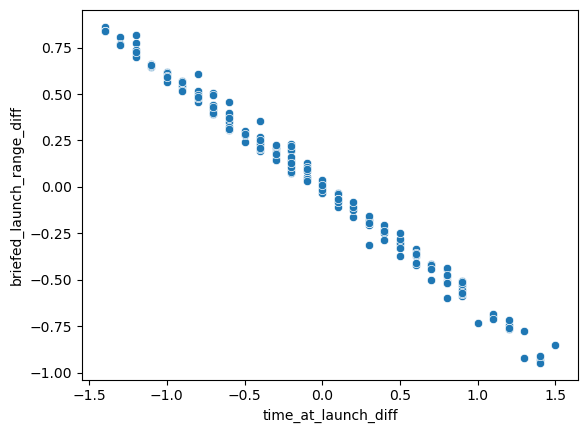

In [4]:
# when viper launches first, viper typically has a longer briefed launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.briefed_launch_range_diff)

<Axes: xlabel='time_at_launch_diff', ylabel='launch_range_diff'>

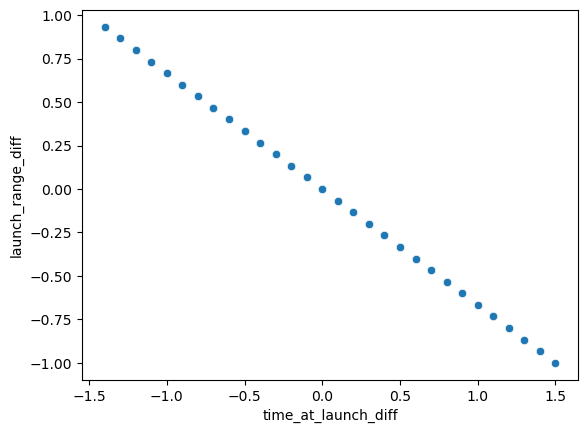

In [5]:
# when viper launches first, viper has a longer launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.launch_range_diff)

<Axes: xlabel='time_at_launch_diff', ylabel='Density'>

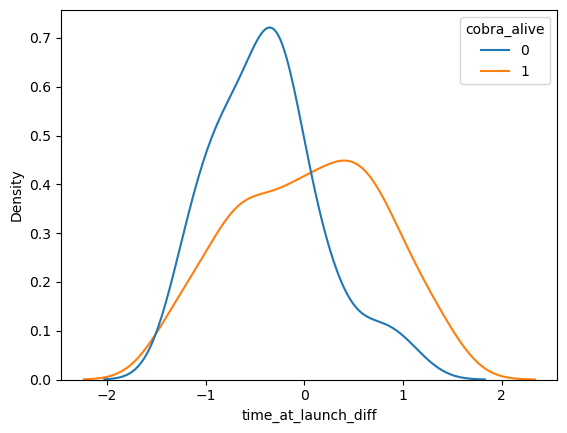

In [6]:
sns.kdeplot(x=df.time_at_launch_diff, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='briefed_evasion_range_diff', ylabel='launch_range_diff'>

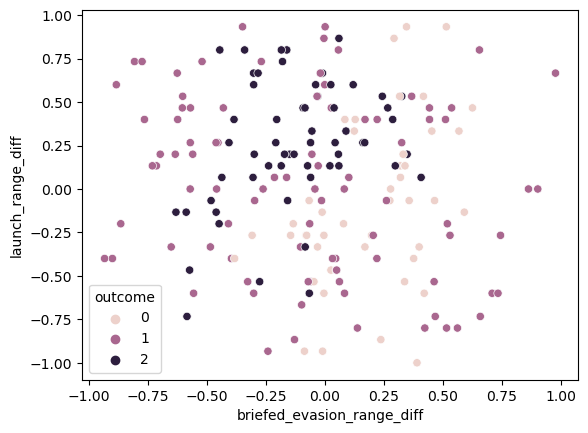

In [7]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(x=df.briefed_evasion_range_diff, y=df.launch_range_diff, hue=df.outcome)

<Axes: xlabel='viper_time_at_launch', ylabel='Density'>

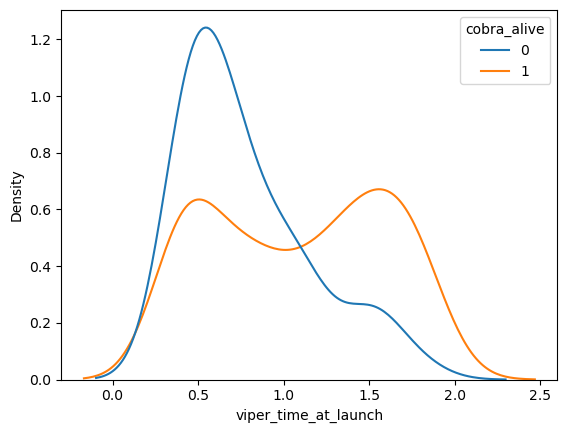

In [8]:
sns.kdeplot(x=df.viper_time_at_launch, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='cobra_time_at_launch', ylabel='Density'>

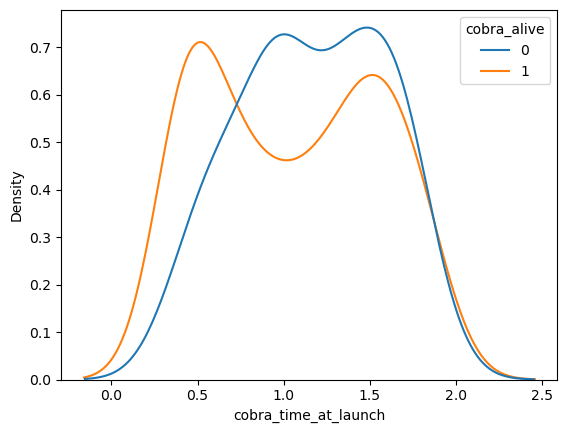

In [9]:
sns.kdeplot(x=df.cobra_time_at_launch, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='norm_viper_launch_range', ylabel='Density'>

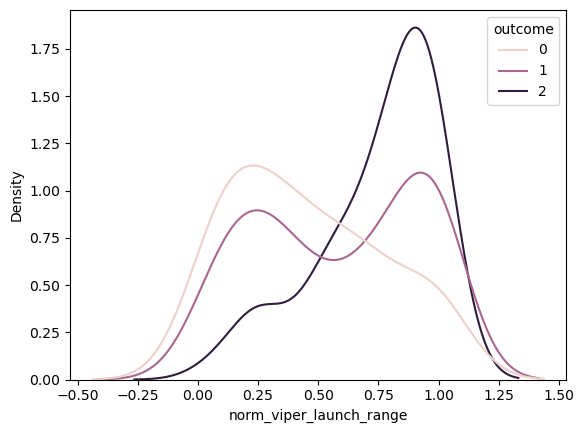

In [592]:
sns.kdeplot(x=df.norm_viper_launch_range, hue=df.outcome, common_norm=False)

<Axes: xlabel='lognorm_viper_launch_range', ylabel='Density'>

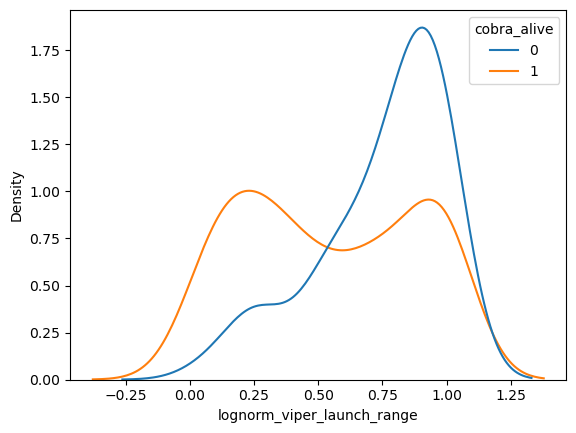

In [10]:
sns.kdeplot(x=df.lognorm_viper_launch_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_cobra_launch_range', ylabel='Density'>

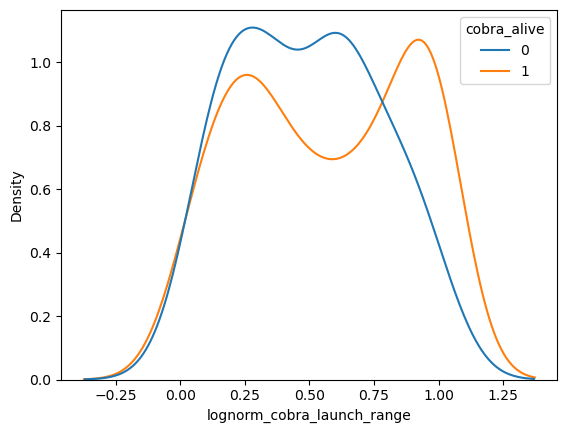

In [11]:
sns.kdeplot(x=df.lognorm_cobra_launch_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_viper_briefed_evasion_range', ylabel='Density'>

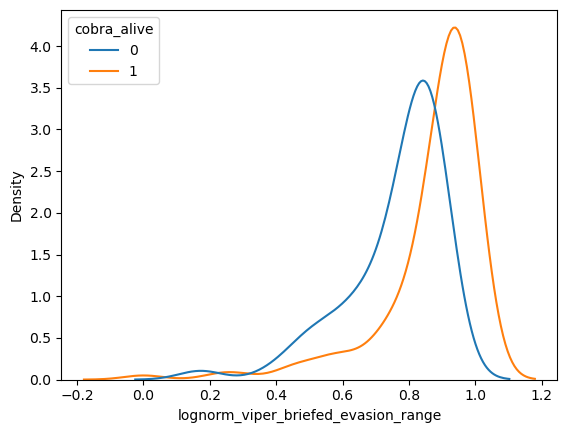

In [12]:
sns.kdeplot(x=df.lognorm_viper_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_cobra_briefed_evasion_range', ylabel='Density'>

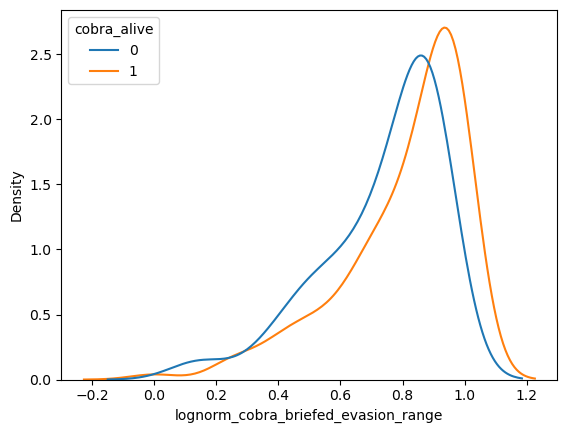

In [13]:
sns.kdeplot(x=df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

Setup train, test dataset

In [14]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

outcome = [
    "outcome"
]

X = torch.tensor(df[input_set2].values, dtype=torch.float)
y = torch.tensor(df.outcome.values, dtype=torch.long).unsqueeze(-1)

In [15]:
# redo this so the min, max values are in the training set for each dim
# manual_seed = 99

train_idx, test_idx = torch.utils.data.random_split(X, [.8, .2], \
    generator=torch.Generator().manual_seed(99))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [134]:
input_dims = train_x.size(-1)
kernel_per_input = 1
active_dims = []

for i in range(input_dims):
    for j in range(3):
        for k in range(kernel_per_input):
            active_dims.append([i])

n_kernels = len(active_dims)
print("number of kernels =", n_kernels)

number of kernels = 12


# Fit the model

In [136]:
gamma_mean = 1.
gamma_std = .3
alpha = gamma_mean**2 / np.sqrt(gamma_std)
beta = gamma_mean / np.sqrt(gamma_std)
lengthscale_prior = gpytorch.priors.GammaPrior(alpha, beta)

batch_shape=torch.Size([1])
kernels = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape, 
                                 lengthscale_prior=lengthscale_prior), 
                       batch_shape=batch_shape)
] * (n_kernels)

likelihoods = ["Categorical"]

model = HetMOGP(train_x, num_lpf=3, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-3, nclasses=3)

if torch.cuda.is_available():
    model = model.cuda()

In [137]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1000 # for actual training
# num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter
# - tightening the lengthscale prior or kernel parameters

initial_lr = 1e-1
final_lr = 1e-7
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})
    
elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

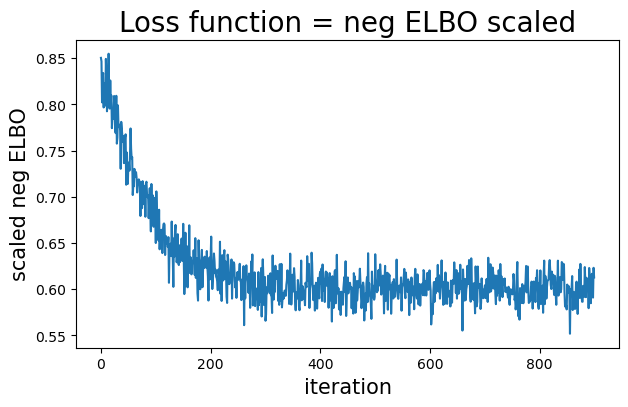

In [138]:
fig, ax = plt.subplots(figsize=(7,4))
loss_start = 100
ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

In [139]:
from pyro.infer import Predictive

predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
predictions = predictive_dist(test_x, None)
y_pred = predictions["hmogp.y_0"].mode(0)[0].t()

In [140]:
predictions_train = predictive_dist(train_x, None)
y_pred_train = predictions_train["hmogp.y_0"].mode(0)[0].t()

Evaluating the model

In [141]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [142]:
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

In [143]:
# posterior predictive dist with outputs of size x.size()
def ppd_given_input(model, x, n_samples=1000):
    x_ = x
    # if not x.is_cuda:
        # x_ = x.cuda()
    
    model.eval()
    with torch.no_grad():
        ppd = model(x_)

    return ppd

# obtain samples from ppd. get median or samples
def sample_from_ppd(ppd, n_samples=1000, return_median=True):
    samples = ppd.sample_n(n_samples)
    if return_median: 
        return samples.mode(0)[0]
    else:
        return samples

lpf_ppd = ppd_given_input(
    model=model,
    x=test_x,
)

lpf_lower, lpf_upper = lpf_ppd.confidence_region()
lpf_mean = lpf_ppd.mean
lpf_lower, lpf_upper, lpf_mean = lpf_lower.cpu(), lpf_upper.cpu(), lpf_mean.cpu()

lpf_ppd_train = ppd_given_input(
    model=model,
    x=train_x,
)

lpf_lower_train, lpf_upper_train = lpf_ppd_train.confidence_region()
lpf_mean_train = lpf_ppd_train.mean
lpf_lower_train, lpf_upper_train, lpf_mean_train = lpf_lower_train.cpu(), lpf_upper_train.cpu(), lpf_mean_train.cpu()

# ppd of observations
y1_ppd = dist.Categorical(logits=lpf_mean)
y1_ppd_train = dist.Categorical(logits=lpf_mean_train)

In [144]:
# Draw some simulated y values
y_sim = torch.stack(
    [sample_from_ppd(y1_ppd)],
    dim=-1
).squeeze(-1)
y_sim_train = torch.stack(
    [sample_from_ppd(y1_ppd_train)],
    dim=-1
).squeeze(-1)

In [145]:
def compute_nlpd(
    dist,
    y,
    sum_log_prob = True
):
    output_dim = len(dist)
    nlpd = dist[0].log_prob(y[...,0])
    if sum_log_prob:
        nlpd = nlpd.sum()
    for d in range(1,output_dim):
        nlpd0 = dist[d].log_prob(y[...,d])
        if sum_log_prob:
            nlpd0 = nlpd0.sum()
        nlpd = torch.stack([nlpd, nlpd0])
    return nlpd

In [146]:
nlpd = compute_nlpd([y1_ppd], test_y)
print("nlpd:", nlpd)

nlpd: tensor(-37.6850)


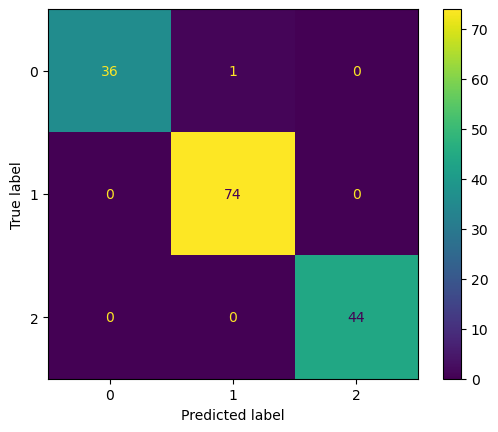

In [147]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(train_y, y_sim_train)
cm_display = ConfusionMatrixDisplay(cm).plot()

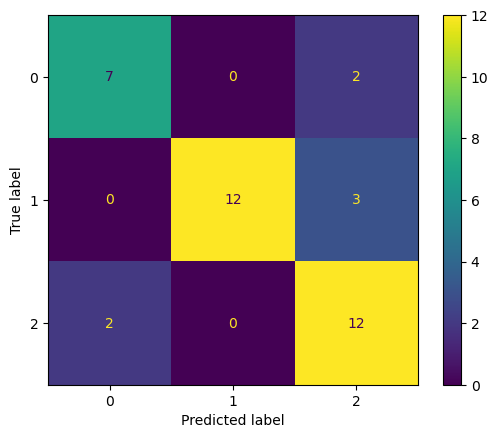

In [148]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_sim)
cm_display = ConfusionMatrixDisplay(cm).plot()

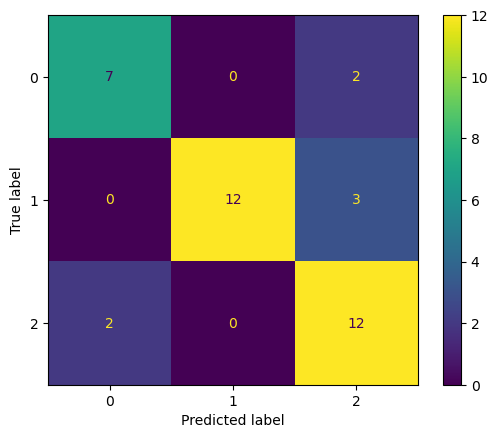

In [556]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_test = confusion_matrix(test_y, y_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot()

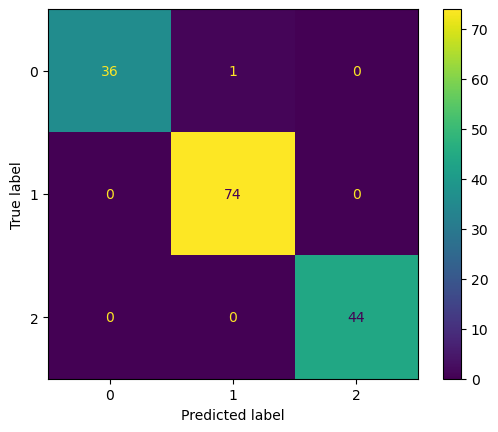

In [429]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_train = confusion_matrix(train_y, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm_train).plot()

Analyse (1) independent latent function, and (2) latent parameter functions

In [152]:
model.eval()

with torch.no_grad():
    latent_dist = model.variational_strategy.latent_dist
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu().detach()

ilf_lower, ilf_upper = latent_dist.confidence_region()
ilf_mean = latent_dist.mean
ilf_lower, ilf_upper, ilf_mean = ilf_lower.cpu(), ilf_upper.cpu(), ilf_mean.cpu()

In [153]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [154]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [622]:
outcome_l = [
    '{COBRA\_WIN}', 
    '{SURVIVED}',
    '{VIPER\_WIN}', 
]

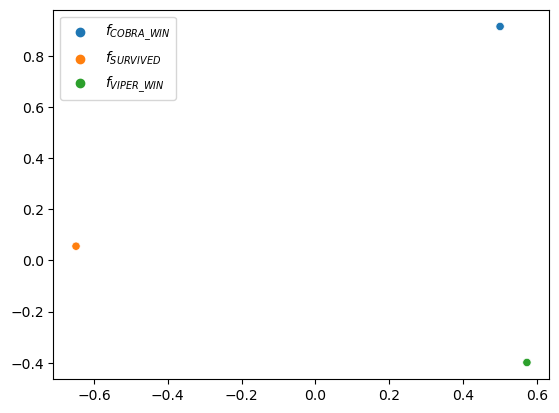

In [626]:
labels = [
    r"$f_{COBRA\_WIN}$", 
    r"$f_{SURVIVED}$", 
    r"$f_{VIPER\_WIN}$",     
]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(x=eigvec[:,0], y=eigvec[:,1], hue=labels)
fig.tight_layout()

In [157]:
inputs = [
    'viper_launch_range',
    'viper_briefed_evasion_range',
    'cobra_launch_range',
    'cobra_briefed_evasion_range',
]

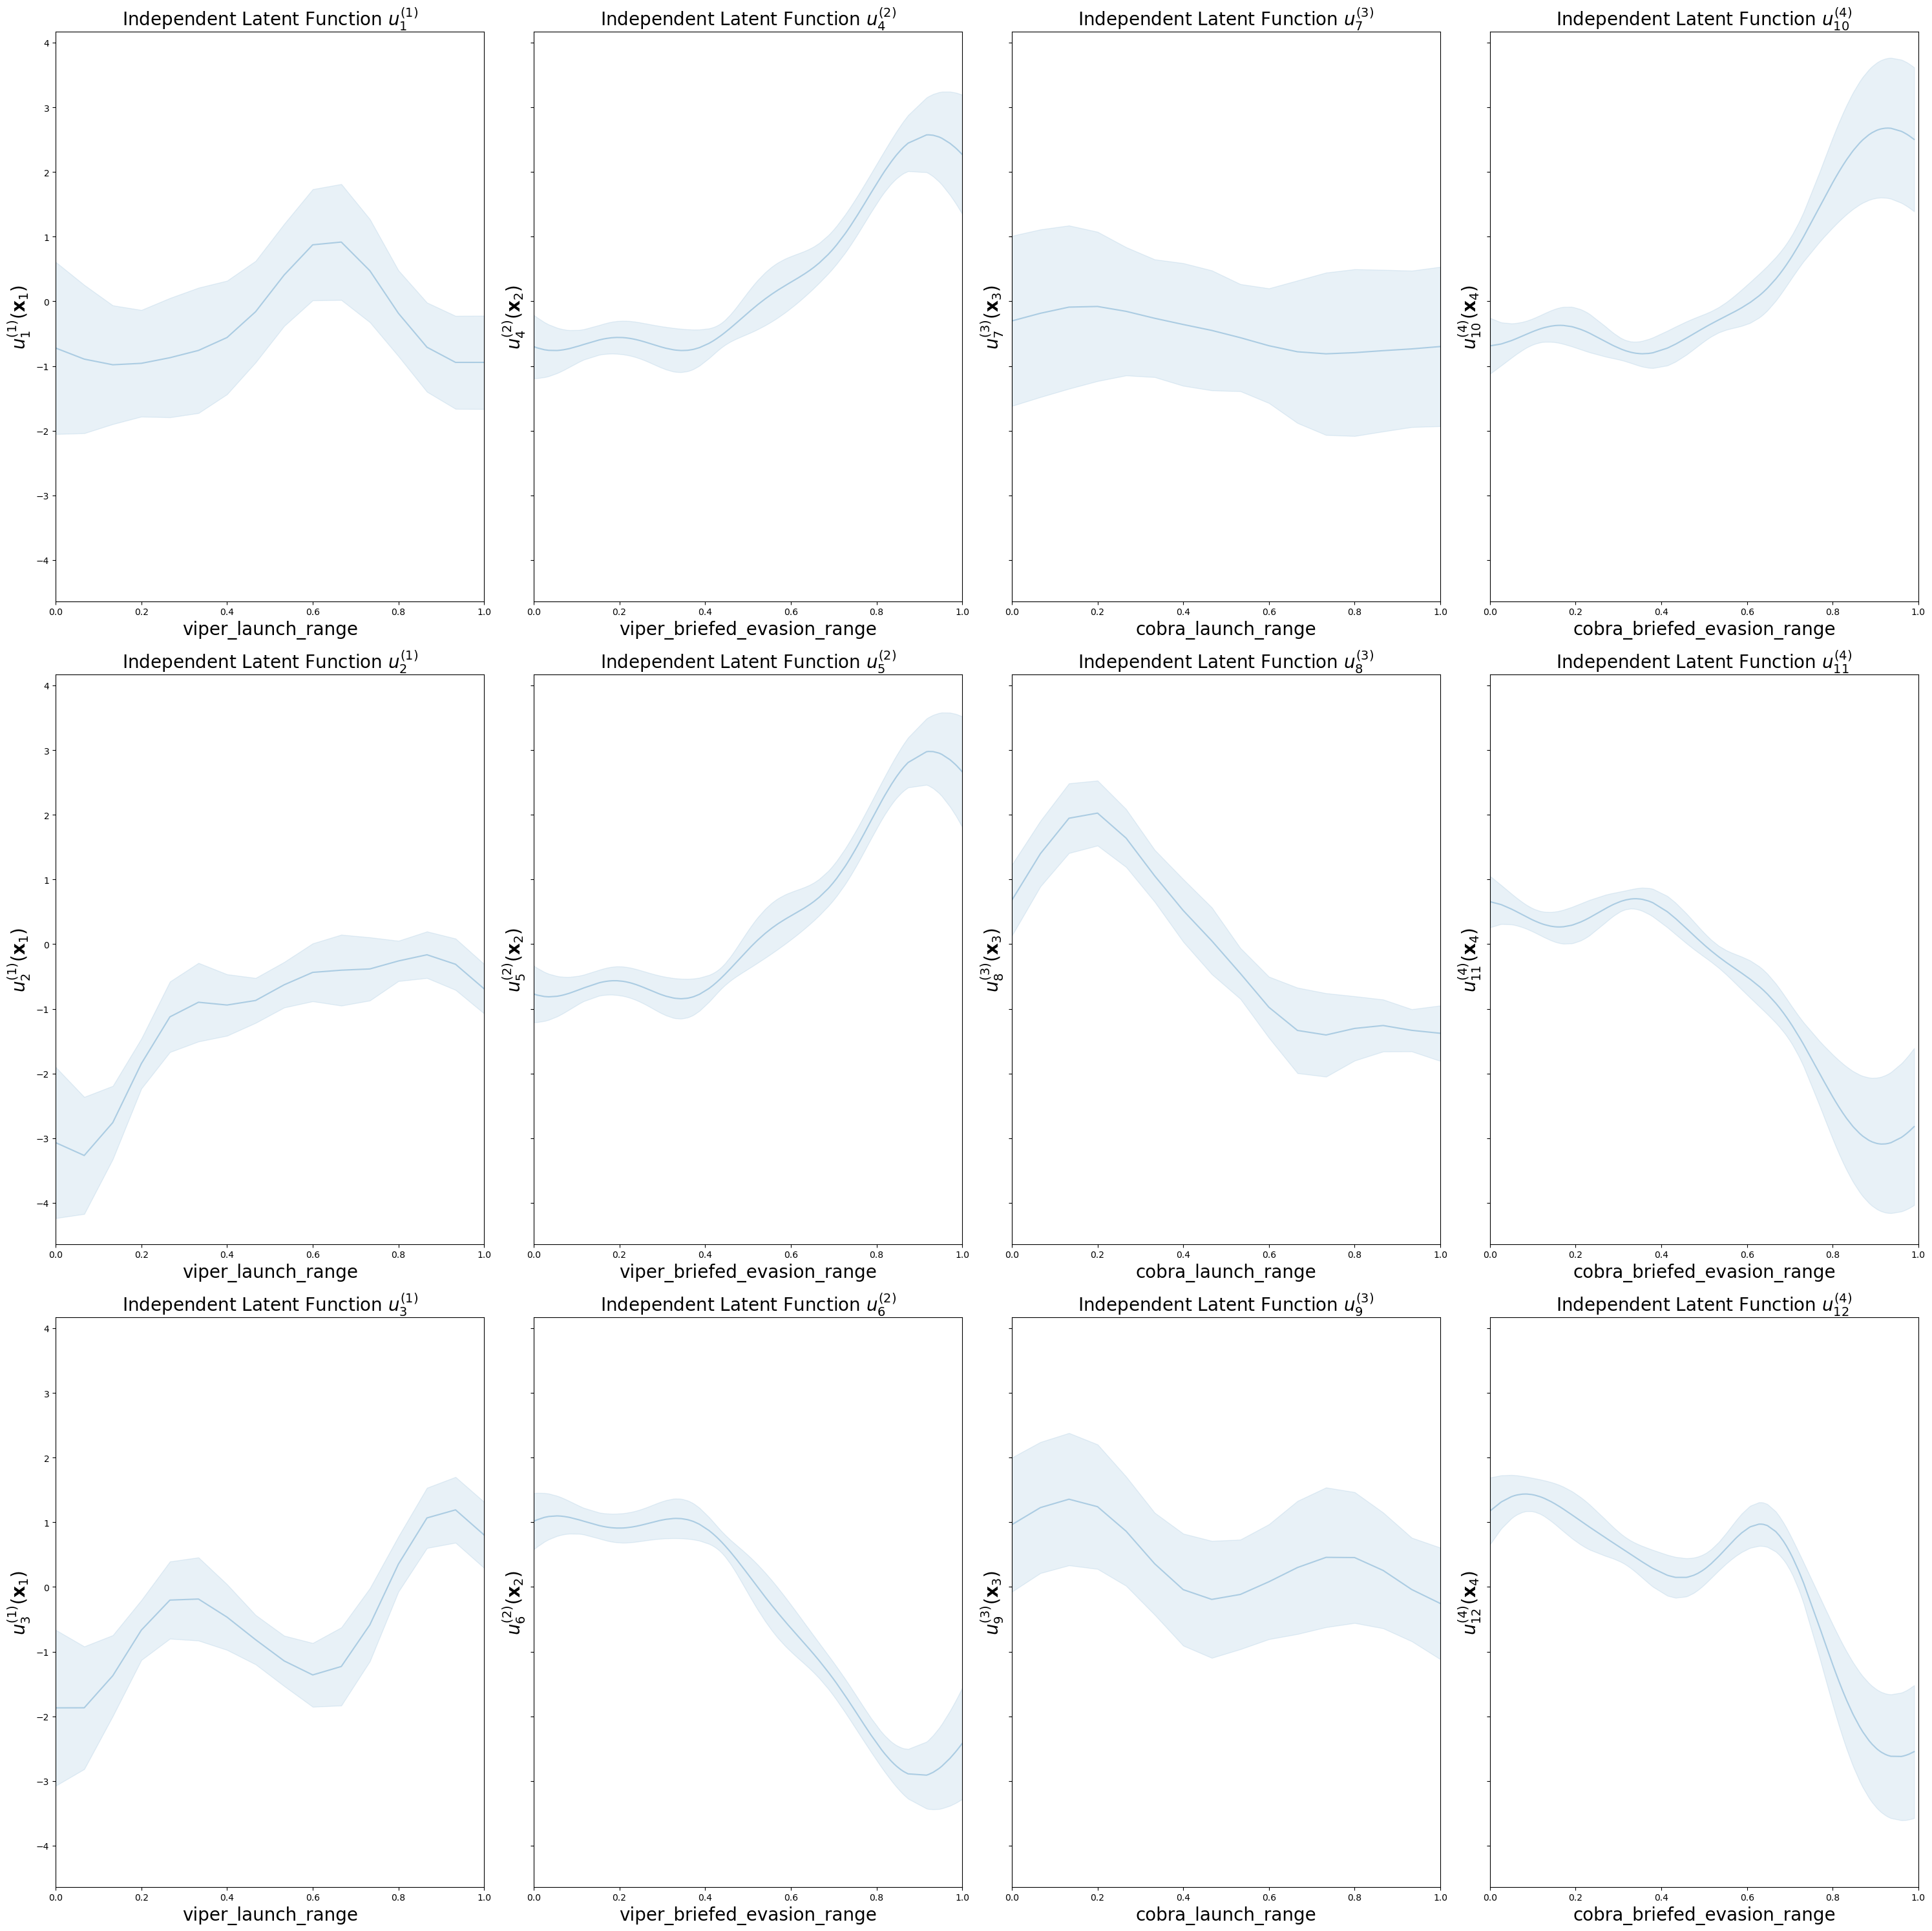

In [158]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 30), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            line, = func[row,j].plot(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
            func[row,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row,j].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            row += 1

fig.tight_layout()

In [159]:
def compute_f_pd_p(x, input_dim, output_d, ilf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,output_d]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

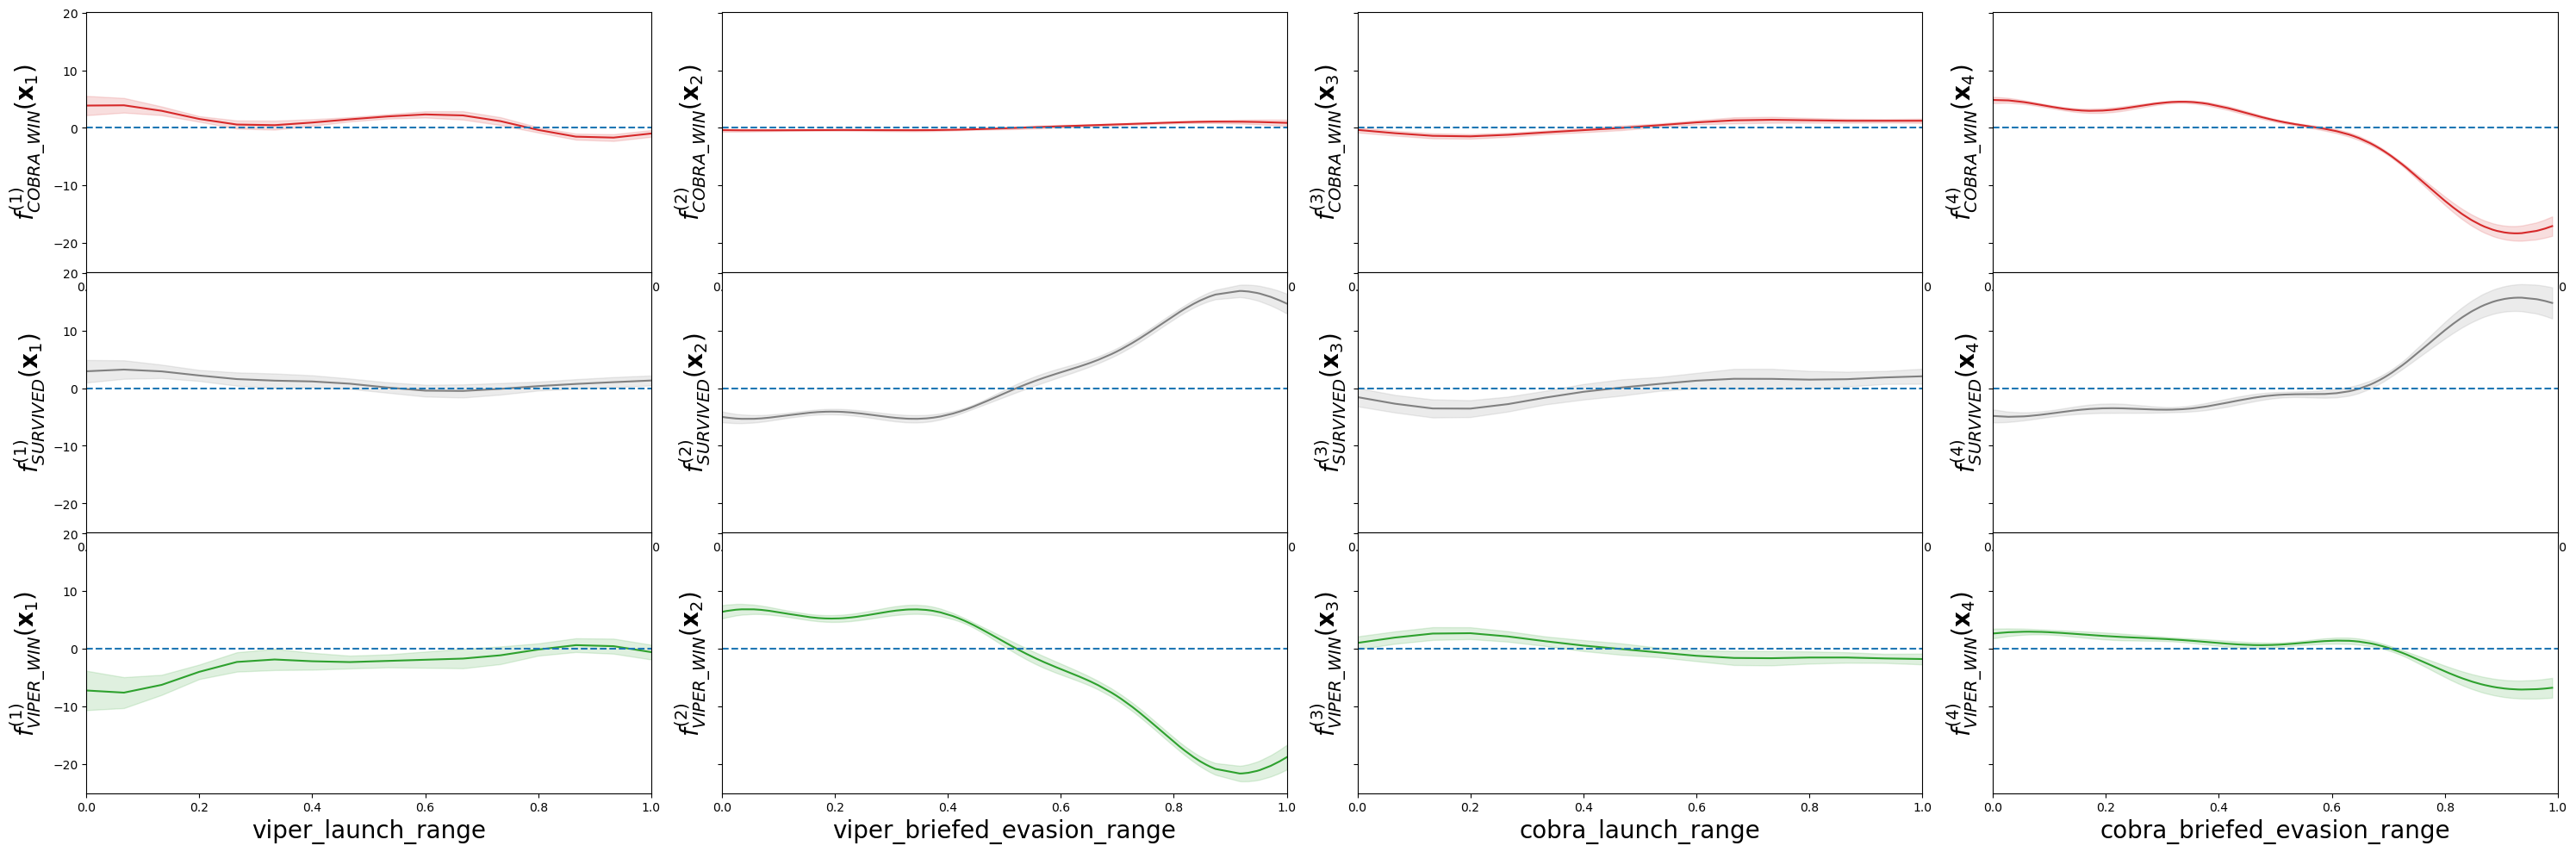

In [756]:

# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 10), sharey=True)
# x="x"
c = ["tab:red", "tab:gray", "tab:green"]

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j]) 
            indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
            _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
            _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
            line, = func[row,j].plot(train_x[indices,j], f_mean, alpha=0.99, c=c[row])
            func[row,j].fill_between(
                train_x[indices,j], f_lower,
                f_upper, alpha=0.15, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            # func[row,j].set_title(f"Raw Latent Parameter Function ${{f_{{{outcome_l[row]}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            func[row,j].hlines(0, 0, 1, ls="--")
            row += 1

fig.tight_layout()
fig.subplots_adjust(hspace=0)

Text(0.0, -40, 'scotts_pi score: 0.7172')

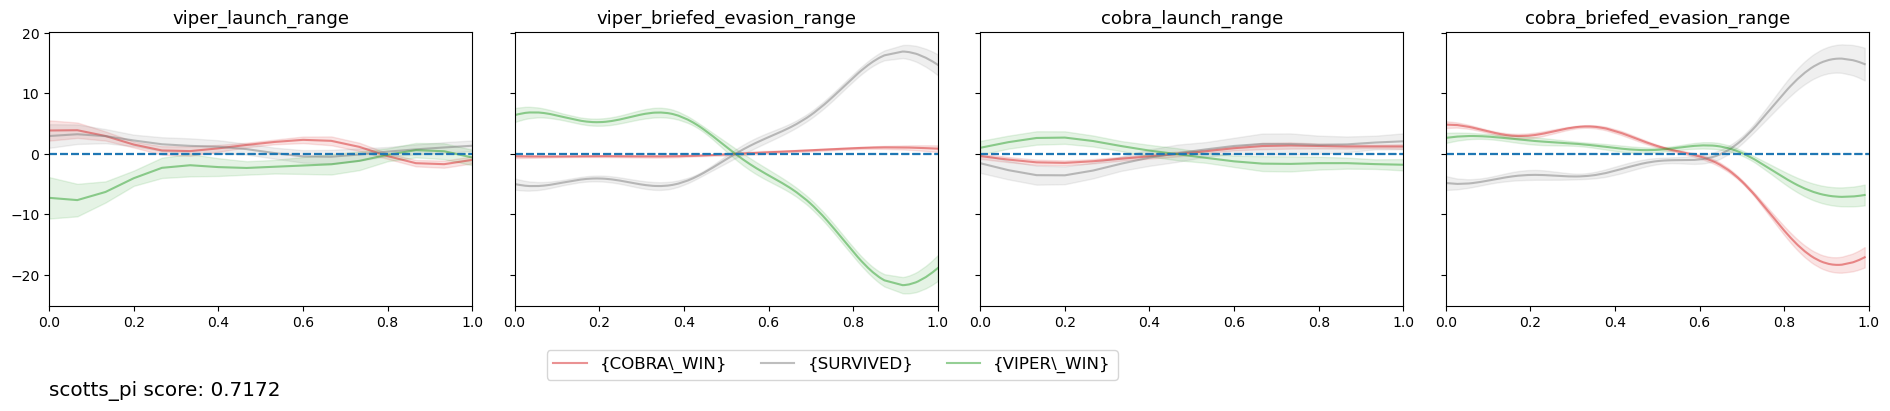

In [651]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(ncols=input_dim, figsize=(19, 3.5), sharey=True)
# x="x"

c = ["tab:red", "tab:gray", "tab:green"]

ilf_idx = 0
for j in range(input_dim):
    for i in range(n_categories):
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, i, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, i, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, i, ilf_upper, lmc_coefficients, active_dims)
        line, = func[j].plot(train_x[indices,j], f_mean, alpha=0.5, label=outcome_l[i], c=c[i])
        func[j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[j].set_xlabel(inputs[j], fontdict={'fontsize':10})
        # func[j].set_ylabel(f"${{f_{{{outcome_l[i]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[j].set_title(inputs[j], fontdict={'fontsize':13})
        func[j].set_xlim([0.,1.])
        func[j].hlines(0, 0, 1, ls="--")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.75, -.3), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -40), fontsize="x-large", annotation_clip=False)

Text(0.0, -40, 'scotts_pi score: 0.7172')

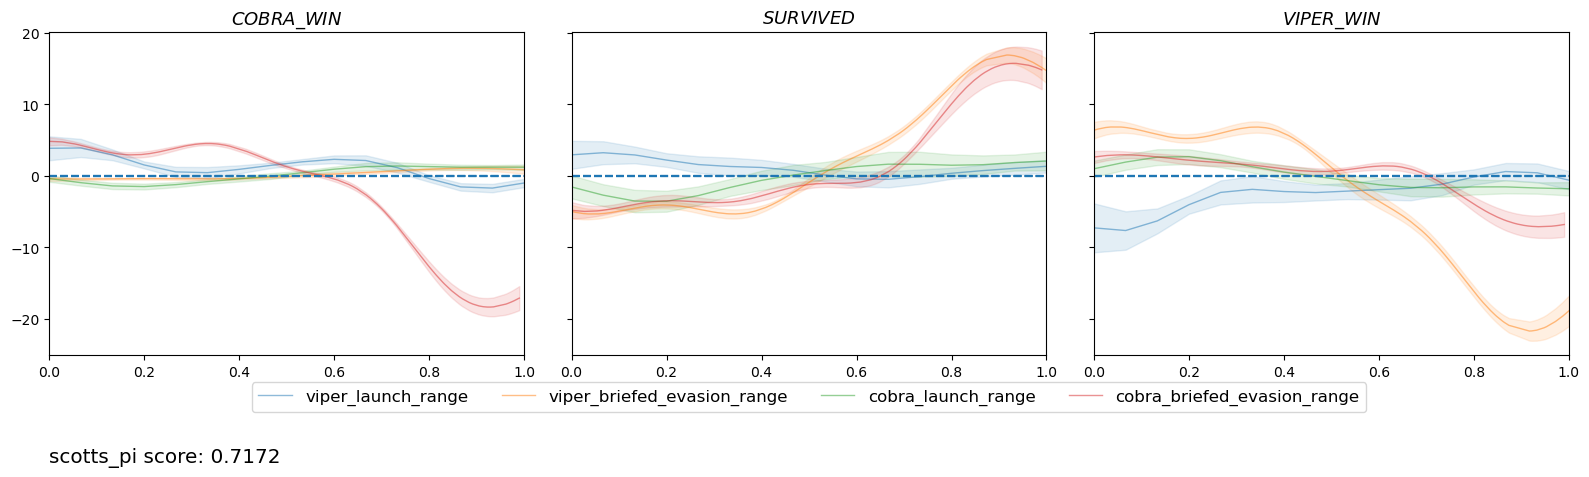

In [650]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 3

# visualize the result
fig, func = plt.subplots(nrows=1, ncols=n_categories, figsize=(16, 4), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
            _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
            _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
            line, = func[row].plot(train_x[indices,j], f_mean, alpha=0.5, lw=1, label=inputs[j])
            func[row].fill_between(
                train_x[indices,j], f_lower,
                f_upper, alpha=0.12, color=line.get_color()
            )
            # func[row].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            # func[row].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row].set_title(f"${{{outcome_l[row]}}}$", fontdict={'fontsize':13})
            func[row].hlines(0, 0, 1, ls="--")
            func[row].set_xlim([0.,1.])
            # func[row].legend()
            row += 1

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.5, -.2), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -40), fontsize="x-large", annotation_clip=False)

In [120]:
# dyanmic alpha by abs(f)
# normalise f_alpha = (abs(f) - abs(f.max())) / (abs(f.max()) - abs(f.min()))

In [514]:
# requires predicting on new data without updating posterior
# train_x[compute_f_pd(train_x, 2, i, ilf_mean, lmc_coefficients, active_dims)[0], 2] 

In [759]:
score = scotts_pi(cm_test, weight_type="unweighted")
print("scotts_pi:", score)

scotts_pi: 0.7172


In [657]:
test_x.shape

torch.Size([38, 4])

In [659]:
test_scenario = torch.rand((1,4))
test_scenario

tensor([[0.2390, 0.9885, 0.8050, 0.2072]])

In [716]:
torch.manual_seed(12)
# test_scenario = torch.rand((1,4))
test_scenario = torch.tensor([[.76, .5, .45, .5]])
# test_scenario.shape
predictive_dist = Predictive(model.model, guide=model.guide, num_samples=250)
predictions = predictive_dist(test_scenario, None)
y_pred = predictions["hmogp.y_0"]

Text(-1.5, -0.1, 'viper_launch: 0.76, viper_evade: 0.50, cobra_launch: 0.45, cobra_evade: 0.50')

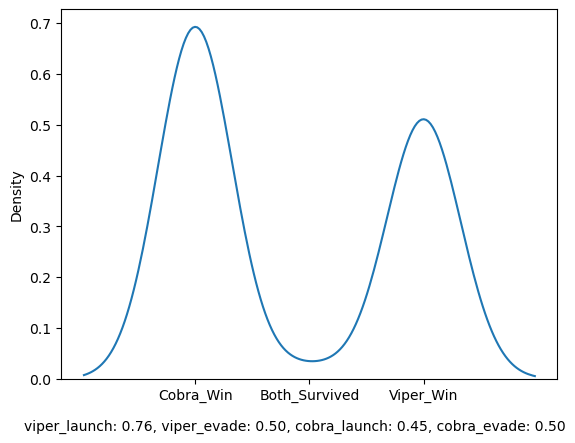

In [755]:
sns.kdeplot(y_pred.flatten())
plt.xticks([0, 1, 2], ["Cobra_Win", "Both_Survived", "Viper_Win"])
plt.annotate(f"viper_launch: {test_scenario[0][0]:.2f}, viper_evade: {test_scenario[0][1]:.2f}, cobra_launch: {test_scenario[0][2]:.2f}, cobra_evade: {test_scenario[0][3]:.2f}", (-1.5,-.1),annotation_clip=False)